twitter.com/0x94305
Simulations of LVR and realized spreads

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from numba import njit, float64
from numba.experimental import jitclass

In [2]:
spec = [
    ('sqrtP', float64),  # this might need to be changed to float32, depending on setup (also in the import above)
    ('L', float64),
    ('Fee', float64)
]

@jitclass(spec)
class AMM:

     def __init__(self, fee=0.0, p = 1200.0, L = 166_666.67):
         """Constructor, instantiates a new AMM pool

         Args:
             fee (float, optional): Pool fee. Defaults to 0.0.
             p (float, optional): Price of token X (eg ETH) in token Y (eg USDT). Defaults to 1200.0.
             L (_type_, optional): Marginal liquidity.
                Defaults to 166_666.67, which is approx 20,000 Y/bps at p=1200.
                In general, to get a realistic L, get liquidity/bps from a Uniswap pool (x),
                and set L=x*10^4/p
         """
         self.sqrtP = sqrt(p)
         self.L = L
         self.Fee = 1 + fee


     def xReserves(self):
         """Gets reserves of X (base) token from the pool.

         The reserves do not include fees and are calculated in Uniswap v2-equivalent units (ambient liquidity).

         Returns:
             float: Reserves of X
         """
         return self.L/self.sqrtP

     def yReserves(self):
         """Gets reserves of Y (quote) token from the pool. 

         The reserves do not include fees and are calculated in Uniswap v2-equivalent units (ambient liquidity).

         Returns:
             float: Reserves of Y
         """        
         return self.L*self.sqrtP

     def tradeToPriceWithFee(self, targetP, gas=0.0):
         """Attempts to perform an arbitrage swap given the target price.

         Args:
             targetP (float): target "efficient" price. If it exceeds the current pool price of X, 
                the function will attempt to buy X for the client (the pool will be selling X).
                The swap must be profitable to the client after the swap fee and gas cost. 
             gas (float, optional): total gas cost of the transaction in Y tokens. Defaults to 0.0.

         Returns:
             x, y, fee: If a profitable arbitrage opportunity is found, then it is executed
                against the pool. The return values of x and y are positive if the client receives 
                the corresponding amount and negative otherwise. x and y already include the swap fee,
                but not gas cost. fee is reported for informational purposes and is measured in Y tokens.
                If no profitable swap is found, the state of the pool is unchanged, and the function 
                returns three zeros. 
         """
         currentP = self.sqrtP**2

         if (self.Fee*currentP > targetP) and (currentP*(2 - self.Fee) < targetP):
            # target price is within the current bid-ask spread, no arb opportunity available
            (x, y, fee) = (0,0,0)
            newSqrtP = self.sqrtP
         elif (self.Fee*currentP < targetP):
            # target price is higher than best ask, try buying X for the client (the pool sells)
            newSqrtP = sqrt(targetP / self.Fee)
            y = -(newSqrtP - self.sqrtP)*self.L
            (x, y, fee) = ((newSqrtP-self.sqrtP)*self.L/(self.sqrtP*newSqrtP),
             y*self.Fee, -y*(self.Fee-1))
         else:
            newSqrtP = sqrt(targetP / (2 - self.Fee))
            y = -(newSqrtP - self.sqrtP)*self.L
            (x, y, fee) = ((newSqrtP-self.sqrtP)*self.L/(self.sqrtP*newSqrtP),
             y*(2 - self.Fee), (y-y*(2 - self.Fee)))

         if (x*targetP + y < gas):
            (x, y, fee) = (0.0, 0.0, 0.0) 
         else:
            self.sqrtP = newSqrtP

         return (x, y, fee)


In [3]:
# Set main parameters here
fee = 0.003
daily_std = 0.05 # daily std of the price of X in Y

blocks_per_day = 24.0*60*5 # 5 blocks per minute = 12s blocks
days = 1.0 # how many days each simulation runs
paths = 10000 # how many price paths to simulate. days*paths = total number of simulated days
gas_fee = 10.0

In [4]:
@njit
def run_simulations(fee, daily_std, blocks_per_day, days, paths, gas_fee):
    # lvr
    # rs1 - realized spread using the AMM price 5 minutes later as markout (25 blocks = 5 minutes)
    # rs2 - realized spread using the efficient price 5 minutes later as markout
    # rs3 - realized spread using the AMM price 1 hour later as markout
    results = np.zeros((4, paths))
    
    for jj in range(paths):
        amm = AMM(fee, 1200.0, 166_666.67)
        
        # save the initial price
        p0 = amm.sqrtP**2
        
        sigma = daily_std/np.sqrt(blocks_per_day) # vol between blocks
        T = int(days*blocks_per_day)

        # Generate a GBM path for prices
        z = np.cumsum(np.random.normal(0.0, sigma, T))
        # Note that we are adding a risk-neutral drift, so that the price process is a martingale
        prices = np.exp(z-(np.arange(T)*sigma**2)/2)
        prices = prices/prices[0]*p0

        # save the initial reserves   
        initial_yReserves = amm.yReserves()

        lvr = 0.0
        amm_prices = np.zeros(T) # we will be saving the AMM prices as we go
        xs = np.zeros(T) # here, we will be storing quantities of x traded
        ys = np.zeros(T)   
        for i in range(T):
            x0, y0, f = amm.tradeToPriceWithFee(prices[i], gas_fee)
            lvr += x0*prices[i] + y0
            amm_prices[i] = amm.sqrtP**2
            xs[i] = x0
            ys[i] = y0

        rs1 = rs2 = rs3 = 0.0

        for i in range(T - 1):
            rs1 += xs[i]*amm_prices[min(i+25, T-1)] + ys[i]
            rs2 += xs[i]*prices[min(i+25, T-1)] + ys[i]
            rs3 += xs[i]*amm_prices[min(i+300, T-1)] + ys[i]

        results[:, jj] = [-x/days/(2*initial_yReserves) for x in [lvr, rs1, rs2, rs3]]

    return results

In [6]:
results = run_simulations(fee, daily_std, blocks_per_day, days, paths, gas_fee)

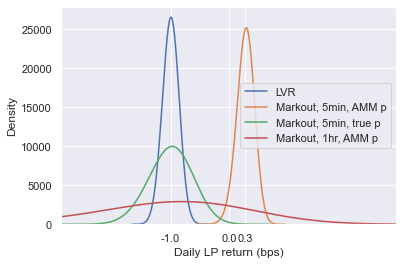

In [7]:
# Now we can plot the results
# The variances are not exactly correct unless days==1 because
# there is one averaged observation for several days. Means should be ok though.

sns.set()

bw_adjust = 5
ax = sns.kdeplot(data=results[0,:], bw_adjust=bw_adjust, label = "LVR")
ax = sns.kdeplot(data=results[1,:], bw_adjust=bw_adjust, label = "Markout, 5min, AMM p")
ax = sns.kdeplot(data=results[2,:], bw_adjust=bw_adjust, label = "Markout, 5min, true p")
ax = sns.kdeplot(data=results[3,:], bw_adjust=bw_adjust, label = "Markout, 1hr, AMM p")

# Choose limits so that the plot looks nice
ax.set_xlim([-0.0003,0.0003])

ax.set(xlabel='Daily LP return (bps)', ylabel='Density')
ax.set_xticks([0, np.mean(results[0, :]), np.mean(results[1,:])])

l = ['0.0'] + ["{:.1f}".format(np.mean(results[s, :]*10000)) for s in 
      [0, 1]]
ax.set_xticklabels(l)

plt.legend()
plt.show()


In [8]:
np.mean(results, 1)

array([-1.04097763e-04,  2.99256626e-05, -1.04332122e-04, -1.03641756e-04])